## Load Dependancies

In [2]:
project_name = 'dhcp'
import os
#get current working directory
cwd = os.getcwd()
git_dir = cwd.split(project_name)[0] + project_name
import sys

#add git_dir to path
sys.path.append(git_dir)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dhcp_params as params

from sklearn.manifold import MDS
import pdb
#from d3blocks import D3Blocks
#d3 = D3Blocks()

import warnings
warnings.filterwarnings('ignore')




In [3]:
atlas = 'wang'


#load atlast name and roi labels
#atlas_name, roi_labels = params.load_atlas_info(atlas)
atlas_info = params.load_atlas_info(atlas)

atlas_name, roi_labels = atlas_info.atlas_name, atlas_info.roi_labels

age_groups = ['infant', 'adult']

#color code rois by network
#inds 1-7 are EVC
#inds 8-11 are ventral
#inds 12-17 are lateral
#inds 18-25 are dorsal

#add networks to roi labels
roi_labels['network'] = ['EVC']*6 + ['ventral']*5 + ['lateral']*6 + ['dorsal']*7

networks = ['EVC', 'ventral', 'lateral', 'dorsal']
network_colors = ['#fd0000', '#be00fd', '#1105d8', 'green']

#expand roi labels to include hemis
all_rois = []
all_networks = []



all_rois = []
all_networks = []
for roi in roi_labels['label']:
    for hemi in params.hemis:
        all_rois.append(f'{hemi}_{roi}')
        all_networks.append(roi_labels[roi_labels['label'] == roi]['network'].values[0])




## Visualization functions

In [4]:
def plot_fc_matrix(corr_mat, roi_labels, file_name):
    #make diagonal to nans
    corr_mat = np.array(corr_mat)
    print(corr_mat.shape)
    #corr_mat = np.fill_diagonal(corr_mat, np.nan)

    #extract upper triangle
    #corr_mat = np.triu(corr_mat)


    sns.heatmap(corr_mat, cmap= 'viridis', cbar =False)
    #make bigger 
    plt.gcf().set_size_inches(12,12)

    #add labels from all_labels
    plt.xticks(np.arange(0.5, len(roi_labels), 1), roi_labels, rotation = 90)
    plt.yticks(np.arange(0.5, len(roi_labels), 1), roi_labels, rotation = 0)
    

    #make background black
    ax = plt.gca()

    #make plot square
    ax.set_aspect('equal', 'box')

    #tight layout
    plt.tight_layout()

    

    if file_name is not None:
        plt.savefig(f'{git_dir}/figures/{file_name}.png')    

    plt.show()
    plt.pause(.001)



In [18]:
def create_mat(df,col = 'fc'):
    #create empty matrix to store infant data
    mat = np.zeros((len(all_rois), len(all_rois)))

    #fill in infant matrix with infant data
    for i, roi1 in enumerate(all_rois):
        for j, roi2 in enumerate(all_rois):
            if roi1 == roi2:
                mat[i,j] = 1
            else:
                mat[i,j] = df[(df['roi1'] == roi1) & (df['roi2'] == roi2)][col].values[0]

    return mat

In [19]:
def plot_mds(fc_mat,  all_rois, all_networks, seed=None, file_name=None):


    #set diagonal to 1
    np.fill_diagonal(fc_mat, 1)



    z_val = 1
    #run MDS on fc matrix
    mds = MDS(n_components = 2, dissimilarity = 'euclidean', random_state = seed)
    mds_results = mds.fit(fc_mat).embedding_

    #plot the edges between rois
    for i in range(len(all_rois)):
        for j in range(len(all_rois)):
            #convert fc_mat to value between min and max
            connection_strength = (fc_mat[i,j] - np.min(fc_mat)) / (np.max(fc_mat) - np.min(fc_mat))

            #set linewidth to be between .1 and 3
            linewidth = .001 + connection_strength * 2.9

            #rescale opacity vals
            opacity_val = .0001 + connection_strength * .15

        
            plt.plot([mds_results[i,0], mds_results[j,0]], [mds_results[i,1], mds_results[j,1]], c = 'k', alpha = opacity_val, linewidth = linewidth, zorder = z_val)
            z_val += 1


    for i, net_id in enumerate(all_networks):
        plt.scatter(mds_results[i,0], mds_results[i,1], c = network_colors[networks.index(net_id)], label = net_id, s =50, edgecolors = 'k', zorder = z_val)
        z_val += 1


    #color code points by network and network_color
    for i, net in enumerate(networks):
        plt.scatter(mds_results[networks==net,0], mds_results[networks==net,1], c = network_colors[i], label = net, zorder = z_val, s = 50)
        z_val += 1

    #add labels
    for i, label in enumerate(all_rois):
        #replace lh_ and rh_ with l and r
        label = label.replace('lh_', 'l')
        label = label.replace('rh_', 'r')

        #add text each point, with the label, with background color
        plt.text(mds_results[i,0]+.025, mds_results[i,1]+.025, label, fontsize = 10, zorder = z_val, color = 'white', bbox=dict(facecolor=network_colors[networks.index(all_networks[i])], alpha=0.7))
        


        #plt.annotate(label, (mds_results[i,0], mds_results[i,1]), zorder = z_val)
        #add box around label
        
        z_val += 1

    #make plot larger
    #plt.rcParams['figure.figsize'] = [15, 15]
    plt.rcParams['figure.figsize'] = [5, 5]

    #remove ticks
    plt.xticks([])
    plt.yticks([])

    #remove axis
    plt.axis('off')

    #tight layout
    plt.tight_layout()


    #if file_name is not None:
    if file_name is not None:
        
        #save plot
        plt.savefig(f'{git_dir}/figures/{file_name}.png')

    
    plt.show()
    plt.pause(.001)


In [20]:

atlas = 'wang'

group_info = params.load_group_params('infant')

#load infant data
infant_df = pd.read_csv(f'{group_info.out_dir}/derivatives/{atlas}/infant_{atlas}_roi_similarity.csv')

#add age column by subtracting scan_age from birth_age
infant_df['age'] = (infant_df['scan_age'] - infant_df['birth_age'])*7

#### MDS for infants on day 1

In [21]:
# extract infants that were scanned on day 1
curr_df = infant_df[infant_df['age'] <= 1]
curr_df_mean = curr_df.groupby(by=['hemi1', 'roi1', 'hemi2','roi2']).median(numeric_only=True).reset_index()
#concat hemi and roi columns to create roi labels
curr_df_mean['roi1'] = curr_df_mean['hemi1'] + '_' + curr_df_mean['roi1']
curr_df_mean['roi2'] = curr_df_mean['hemi2'] + '_' + curr_df_mean['roi2']

#extract fc matrix
fc_mat = create_mat(curr_df_mean, col = 'fc')
#convert to pandas df
fc_mat_df = pd.DataFrame(fc_mat, columns = all_rois, index = all_rois)
#save
fc_mat_df.to_csv(f'{git_dir}/results/infant_{atlas}_fc_mat_day1.csv')


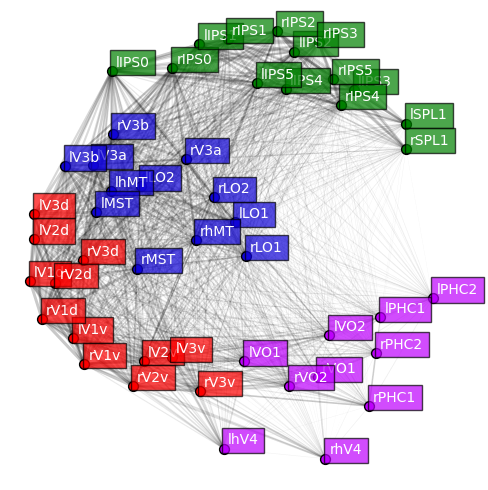

In [25]:
#load data and make mds
fc_mat_df = pd.read_csv(f'{git_dir}/results/infant_{atlas}_fc_mat_day1.csv', index_col = 0).values

plot_mds(fc_mat_df, all_rois, all_networks, seed = 14, file_name = f'infant_{atlas}_mds_day1')

#### MDS for infants at different points of gestation

In [26]:
age_bins = [26,33, 38,42,46]
age_groups = ['pre','early','term','post']

#create mats for each age group
for i in range(len(age_bins)-1):
    curr_df = infant_df[(infant_df['scan_age'] >= age_bins[i]) & (infant_df['scan_age'] < age_bins[i+1])]
    curr_df_mean = curr_df.groupby(by=['hemi1', 'roi1', 'hemi2','roi2']).median(numeric_only=True).reset_index()
    #concat hemi and roi columns to create roi labels
    curr_df_mean['roi1'] = curr_df_mean['hemi1'] + '_' + curr_df_mean['roi1']
    curr_df_mean['roi2'] = curr_df_mean['hemi2'] + '_' + curr_df_mean['roi2']

    #extract fc matrix
    fc_mat = create_mat(curr_df_mean, col = 'fc')
    #convert to pandas df
    fc_mat_df = pd.DataFrame(fc_mat, columns = all_rois, index = all_rois)
    #save
    fc_mat_df.to_csv(f'{git_dir}/results/infant_{atlas}_fc_mat_{age_groups[i]}.csv')

pre


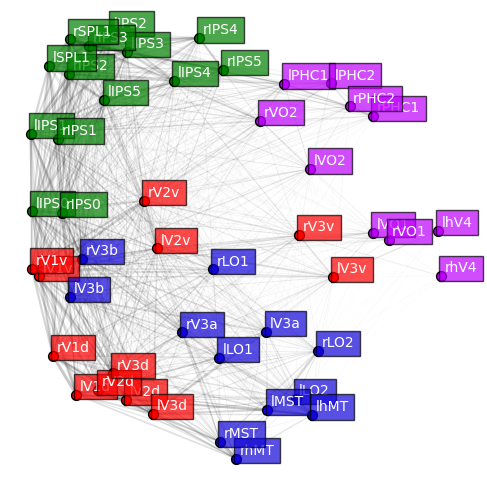

early


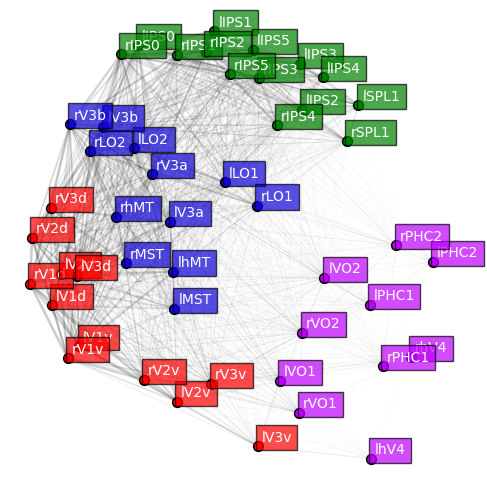

term


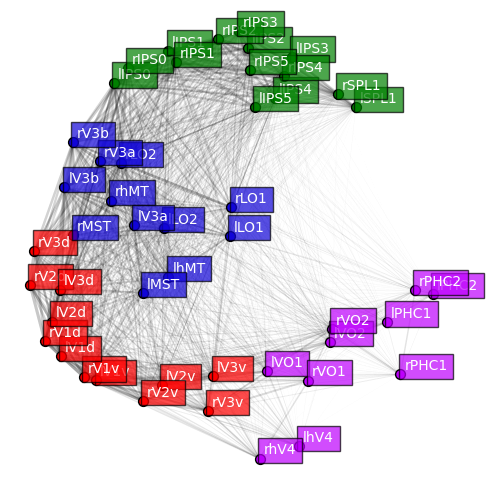

post


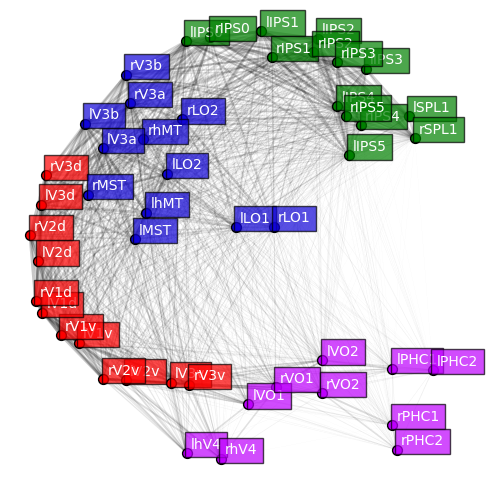

In [27]:
age_groups = ['pre','early','term','post']
seeds =[42,31,40,14]

for i, age_group in enumerate(age_groups):
    print(age_group)
    #load data and make mds
    fc_mat_df = pd.read_csv(f'{git_dir}/results/infant_{atlas}_fc_mat_{age_group}.csv', index_col = 0).values

    plot_mds(fc_mat_df, all_rois, all_networks, seed = seeds[i], file_name = f'infant_{atlas}_mds_{age_group}')


### Plot group MDS

Plotting MDS for infant group


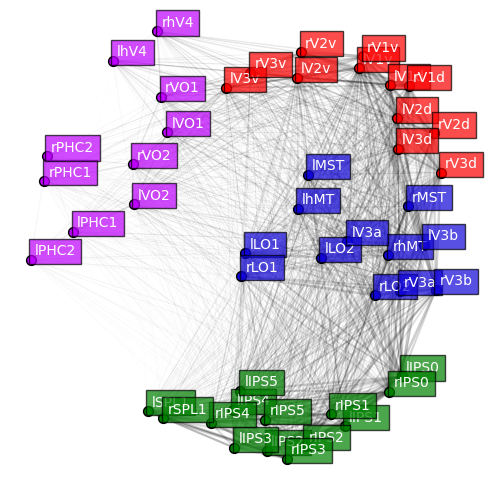

Plotting MDS for adult group


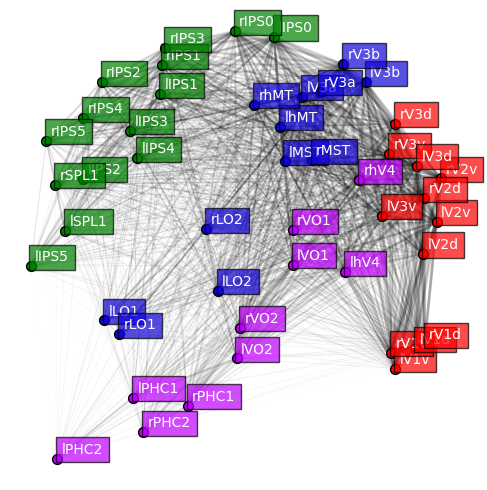

Plotting cross-hemi MDS for infant group


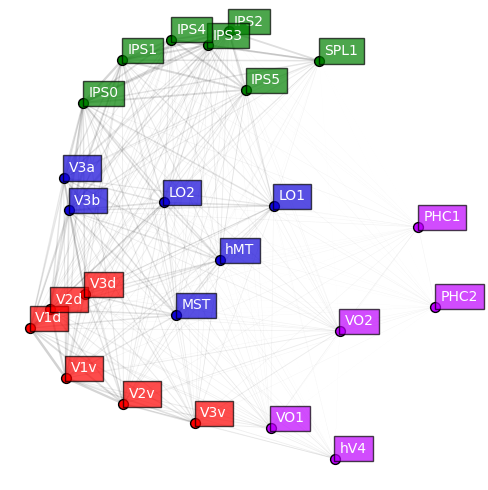

Plotting cross-hemi MDS for adult group


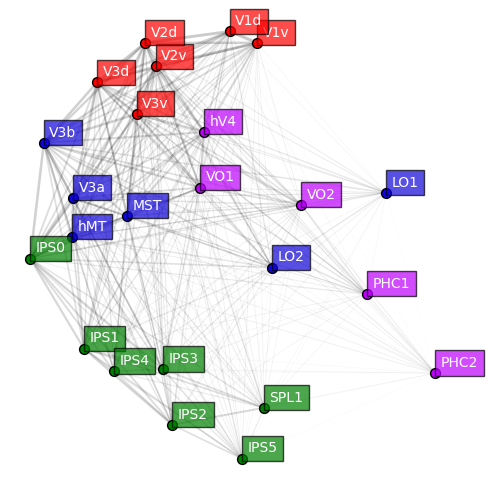

In [17]:

'''within-hemi'''

seeds = [52,40]
for group in age_groups:
    #raw_data_dir, raw_anat_dir, raw_func_dir, out_dir, anat_suf, func_suf, brain_mask_suf, group_template,template_name = params.load_group_params(group)

    #load median fc matrix
    median_fc = pd.read_csv(f'{params.results_dir}/group_fc/{group}_{atlas}_median_fc.csv', header = None).values

 
    #find seed based on group
    seed = seeds[age_groups.index(group)]

    #define all rois and networks
    all_rois = []
    all_networks = []
    for roi in roi_labels['label']:
        for hemi in params.hemis:
            all_rois.append(f'{hemi}_{roi}')
            all_networks.append(roi_labels[roi_labels['label'] == roi]['network'].values[0])
    print(f'Plotting MDS for {group} group',)
    plot_mds(median_fc, all_rois, all_networks, seed = seed, file_name = f'{group}_all_roi_mds')

'''cross-hemi'''
seeds = [20,34]
for group in age_groups:
    seed = seeds[age_groups.index(group)]
    #define all rois and networks
    all_rois = []
    all_networks = []
    for roi in roi_labels['label']:

        all_rois.append(f'{roi}')
        all_networks.append(roi_labels[roi_labels['label'] == roi]['network'].values[0])
    #load median cross hemi fc matrix
    median_cross_hemi_fc = pd.read_csv(f'{params.results_dir}/group_fc/{group}_{atlas}_median_cross_hemi_fc.csv', header = None).values
    print(f'Plotting cross-hemi MDS for {group} group')
    plot_mds(median_cross_hemi_fc,all_rois, all_networks, seed= seed,  file_name =f'{group}_cross_hemi_mds')



### Create MDS by infant ages

Plotting MDS for 0 group


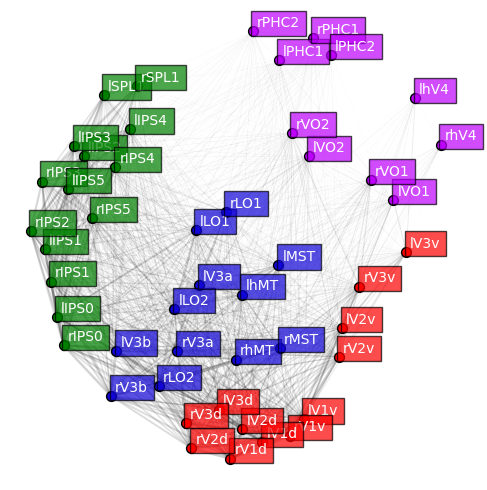

Plotting MDS for 1 group


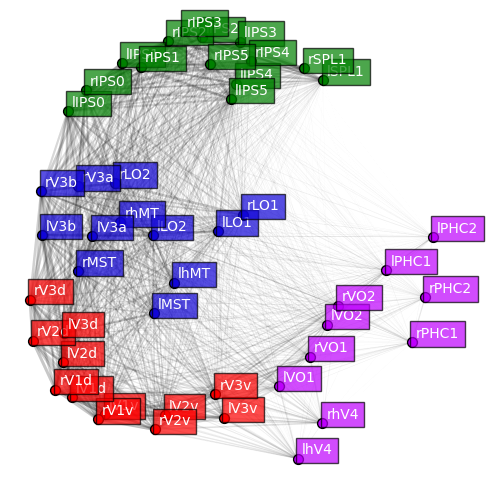

Plotting cross-hemi MDS for 0 group


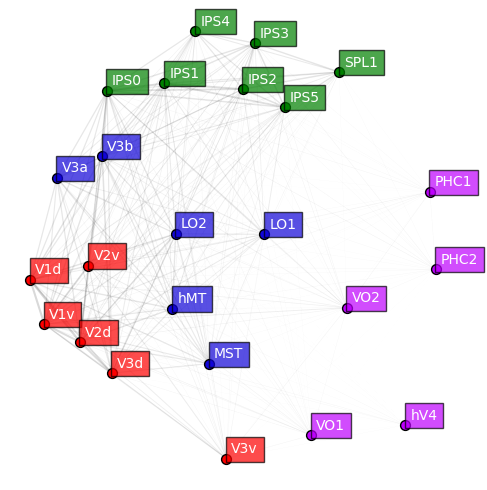

Plotting cross-hemi MDS for 1 group


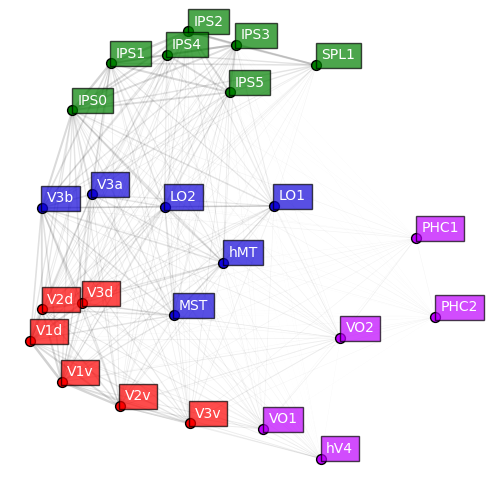

In [27]:
seed = 52
for group in [0,1]:
    #raw_data_dir, raw_anat_dir, raw_func_dir, out_dir, anat_suf, func_suf, brain_mask_suf, group_template,template_name = params.load_group_params(group)

    #load median fc matrix
    median_fc = pd.read_csv(f'{params.results_dir}/group_fc/infant_{atlas}_median_fc_age_group_{group}.csv', header = None).values

 
    #find seed based on group
    #seed = seeds[age_groups.index(group)]

    #define all rois and networks
    all_rois = []
    all_networks = []
    for roi in roi_labels['label']:
        for hemi in params.hemis:
            all_rois.append(f'{hemi}_{roi}')
            all_networks.append(roi_labels[roi_labels['label'] == roi]['network'].values[0])
    print(f'Plotting MDS for {group} group',)
    plot_mds(median_fc, all_rois, all_networks, seed = seed, file_name = f'infant_all_roi_mds_age_group_{group}')

'''cross-hemi'''
seed = 20
for group in [0,1]:
    
    #define all rois and networks
    all_rois = []
    all_networks = []
    for roi in roi_labels['label']:

        all_rois.append(f'{roi}')
        all_networks.append(roi_labels[roi_labels['label'] == roi]['network'].values[0])
    #load median cross hemi fc matrix
    median_cross_hemi_fc = pd.read_csv(f'{params.results_dir}/group_fc/infant_{atlas}_median_cross_hemi_fc_age_group_{group}.csv', header = None).values
    print(f'Plotting cross-hemi MDS for {group} group')
    plot_mds(median_cross_hemi_fc,all_rois, all_networks, seed= seed,  file_name =f'infant_cross_hemi_mds_age_group_{group}')


In [22]:
median_fc_0 = pd.read_csv(f'{params.results_dir}/group_fc/infant_{atlas}_median_fc_age_group_0.csv', header = None).values
median_fc_1 = pd.read_csv(f'{params.results_dir}/group_fc/infant_{atlas}_median_fc_age_group_1.csv', header = None).values


In [23]:
median_fc_0 == median_fc_1

array([[ True, False, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       ...,
       [False, False, False, ...,  True, False, False],
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False,  True]])

### Create Chord plots

In [ ]:
def create_chord_plot(df,group):
    d3 = D3Blocks(chart='Chord', frame=False)

    d3.chord(df, opacity=df['weight'])


    #loop through rois and assign color
    for i, roi in enumerate(df['source']):
        d3.node_properties.get(roi)['color']=df['color'][i]

        d3.edge_properties.loc[d3.edge_properties['source'] == roi,'color'] = df['color'][i]


    d3.show(filepath = f'{git_dir}/figures/{group}_chord_plot.html')

In [ ]:

groups = ['infant', 'adult']
group_df = pd.DataFrame()
for group in groups:

    all_rois = []
    
    all_networks = []
    for roi in roi_labels['label']:
        for hemi in params.hemis:
            all_rois.append(f'{hemi}_{roi}')
            all_networks.append(roi_labels[roi_labels['label'] == roi]['network'].values[0])

            
    fc = pd.read_csv(f'{params.results_dir}/group_fc/{group}_wang_median_fc.csv', header = None).values

    #set diagonal to nan
    np.fill_diagonal(fc, np.nan)

    #convert to pandas dataframe and melt
    df = pd.DataFrame(fc, index = all_rois, columns = all_rois)
    df = pd.melt(df, var_name ='target',value_name='weight', ignore_index=False)



    #convert index to column called source
    df = df.reset_index()
    df = df.rename(columns = {'index':'source'})

    for roi in df['source']:
        #find index of roi in all_labels
        idx = all_rois.index(roi)
        #get network
        network = all_networks[idx]
        #add to dataframe
        df.loc[df['source'] == roi, 'network'] = network

    #split columns by _
    df[['hemi', 'source']] = df['source'].str.split('_', expand = True)
    df[['hemi', 'target']] = df['target'].str.split('_', expand = True)

    #drop nan rows
    df = df.dropna()

    #drop rows with same source and target
    df = df[df['source'] != df['target']]

    #average rows with same source and target
    df = df.groupby(['source', 'target','network']).mean().reset_index()

    #create new column with color for each network
    df['color'] = df['network'].map({'EVC':'#000000', 'ventral':'#00b04f', 'lateral':'#0070c0', 'dorsal':'#c00000'})


    #drop network column
    #df = df.drop(columns = 'network')
    #drop color
    #df = df.drop(columns = 'color')

    #reorder by network
    df = df.sort_values(by = 'network')

    #reset index
    df = df.reset_index(drop = True)


    #add index number from roi_labels to the beginning of each source label in form 000_label
    for roi in roi_labels['label']:
        df.loc[df['source'] == roi, 'source'] = f'{roi_labels[roi_labels["label"] == roi]["index"].values[0]:03d}_{roi}'
        df.loc[df['target'] == roi, 'target'] = f'{roi_labels[roi_labels["label"] == roi]["index"].values[0]:03d}_{roi}'


    #create chord plot
    create_chord_plot(df,group)

    group_df[group] = df['weight'].values

group_df['source'] = df['source']
group_df['target'] = df['target']
group_df['network'] = df['network']
group_df['color'] = df['color']

In [ ]:
#zscore infant and adult columns separately
group_df['infant'] = (group_df['infant'] - group_df['infant'].mean()) / group_df['infant'].std()
group_df['adult'] = (group_df['adult'] - group_df['adult'].mean()) / group_df['adult'].std()

#create new column that subtracts adult from infant
group_df['weight'] = group_df['adult'] - group_df['infant']

#add min as constant
group_df['weight'] = group_df['weight'] + np.abs(group_df['weight'].min())

#set bottom 50% to 0.01
#perc = .8
#group_df.loc[group_df['weight'] < group_df['weight'].quantile(perc), 'weight'] = 0

#exponential transform
group_df['weight'] = np.exp(group_df['weight'])


In [ ]:
create_chord_plot(group_df,'subtract')